Imports

In [1]:
import os
import scipy as sp
import numpy as np
import time
from matplotlib import pyplot as plt
from stereoid.oceans.forward_models import SAR_spectra as SAR_model
from stereoid.instrument import ObsGeo
import drama.geo as sargeo
from stereoid.oceans.waves.wave_spectra import elfouhaily
from stereoid.oceans.waves.wave_spectra import elfouhaily_spread

# output folder
outpath='/Users/marcelmac/Documents/Papers/BistaticSARtransform/'

# Run ID
mode = "IWS"
run_id='2021_1'

# stereoid path
path='/Users/marcelmac//Data/Harmony'
pardir=path + '/PAR/'
parfile=pardir + 'Hrmny_' + run_id + '.cfg'
main_dir=path + ''

In [2]:
# Incident angle
incm = np.deg2rad(35)
along_track_separation=350E3 # should be consistent with the PAR file
swth_bst = sargeo.SingleSwathBistatic(par_file=parfile, dau=along_track_separation)
# Observation geometry calculated from orbit
obsgeo = ObsGeo.from_swath_geo(incm, swth_bst, ascending=True)
# receiver/transmitter range
Ix=np.argmin(np.absolute(incm-np.degrees(swth_bst.master_inc[0,:])))
Rt=swth_bst.master_range[0,Ix]
Rr=swth_bst.slave_range[0,Ix]
# angles
bist_ang=obsgeo.bist_ang
inc_m=obsgeo.inc_m
inc_b=obsgeo.inc_b
# rotation angle for MACS and cut-off
alpha_rot=np.arctan(np.sin(bist_ang)*np.sin(inc_b)/(np.sin(inc_m)+ np.cos(bist_ang)*np.sin(inc_b)))

Make a spectrum

In [3]:
# wave numbers in a Cartesian grids (kx=cross,ky=along)
g = 9.81
scene_size = 5000  # maximum wavelength (size of image)
dx = 10
dy = 20
Nx=int(scene_size/dx)
Ny=int(scene_size/dy)
kx = np.ones( (1, Nx) )
ky = np.ones( (Ny, 1) )
dk = 2 * np.pi / scene_size  # fundamental frequency
kx[ 0, 0:int( Nx / 2 ) ] = dk * np.arange( 0, Nx / 2 )
kx[ 0, int( Nx / 2 ): ] = dk * np.arange( -Nx / 2, 0 )
kx = np.dot( np.ones( (Ny, 1) ), kx )
ky[ 0:int( Ny / 2 ), 0 ] = dk * np.arange( 0, Ny / 2 )
ky[ int( Ny / 2 ):, 0 ] = dk * np.arange( -Ny / 2, 0 )
ky = np.dot( ky, np.ones( (1, Nx) ) )
k = np.sqrt( kx ** 2 + ky ** 2 )
omega = np.sqrt( g * k )  # angular velocity
phi = np.arctan2( ky, kx )  # 0 is cross-track direction waves, 90 along-track
shp=k.shape

SW=1
WI=1

## swell
if SW==1:
    # inputs for the Gaussian wave spectrum
    sw_f_p=0.08 # peak frequency
    sw_sigma_f=0.007 # spread in frequency
    sw_sigma_phi=np.deg2rad(8) # spreadk in direction
    sw_Hs=2 # significant wave height
    sw_k_p=(sw_f_p*2*np.pi)**2/g
    sw_lambda_p=(2*np.pi)/sw_k_p
    print(sw_lambda_p)
    
## wind
if WI==1:
    wind_U=10 # wind speed
    wind_fetch=200E3 # fetch
    wind_dir=np.deg2rad(45) # wind direction

MTF='Kirchhoff'

243.9546862080458


In [4]:
phi_d=np.arange(-186,188,2)
KX_m=np.zeros(len(phi_d)) # location of the maximum power in the SAR spectrum (mono)
KY_m=np.zeros(len(phi_d)) # location of the maximum power in the SAR spectrum
P_m=np.zeros(len(phi_d)) # maximum power
KX_f=np.zeros(len(phi_d)) # location of the maximum power in the SAR spectrum (forward)
KY_f=np.zeros(len(phi_d)) # location of the maximum power in the SAR spectrum
P_f=np.zeros(len(phi_d)) # maximum power
KX_b=np.zeros(len(phi_d)) # location of the maximum power in the SAR spectrum (backward)
KY_b=np.zeros(len(phi_d)) # location of the maximum power in the SAR spectrum
P_b=np.zeros(len(phi_d)) # maximum power
KX_s=np.zeros(len(phi_d)) # location of the maximum power in the input spectrum
KY_s=np.zeros(len(phi_d)) # location of the maximum power in the input spectrum
P_sm=np.zeros(len(phi_d)) # power at max input spectrum
P_sf=np.zeros(len(phi_d)) # power at max input spectrum
P_sb=np.zeros(len(phi_d)) # power at max input spectrum
for i in range(0,len(phi_d)):
    if np.mod(i,10) == 0:
        print(i)
    
    ###### Swell + wind waves
    phi_s=np.deg2rad(phi_d[i]) # wind and swell direction (both same)

    sw_Sp=0
    sw_D=0
    wi_Sp=0
    wi_D=0
    if SW==1:
        # frequency spectrum
        f=0.5/np.pi*np.sqrt(g*k)
        fac_f=0.25/np.pi*np.sqrt(g/k)
        amp=(sw_Hs/4)**2/(sw_sigma_f*np.sqrt(2*np.pi))
        sw_Sp=(amp*np.exp(-(f-sw_f_p)**2/(2*sw_sigma_f**2)) + 1E-5) * fac_f

        # directional distribution
        dphi = (phi_s-phi + np.pi) % (2 * np.pi) - np.pi # including unwrapping
        sw_D=np.exp(-dphi**2/(2*sw_sigma_phi**2))/(2*np.pi*sw_sigma_phi**2)**0.5 # directional component
    
    if WI==1:
        # wave-number spectrum
        wi_Sp=elfouhaily(k,wind_U,wind_fetch)
        wi_Sp[0,0]=0

        # directional distribution
        dphi = (np.deg2rad(wind_dir)-phi+np.pi) % (2 * np.pi) - np.pi # including unwrapping
        wi_D=elfouhaily_spread(k, dphi, wind_U, wind_fetch)
        wi_D[0,0]=0
    
    # spectrum
    S=sw_Sp*sw_D/k+wi_Sp*wi_D/k
    S[0,0]=0

    # scaling
    S=S*Nx*Ny*dk*dk
    wn_grid={"S": S,"k_x": kx,"k_y": ky}
    
    # find point of maximum
    I=np.argmax(S)
    I2=np.unravel_index(I, np.array(S).shape)
    #print(I2)
    
    # make some x and y vectors
    dx=scene_size/Nx
    dy=scene_size/Ny
    x=np.arange(0,scene_size,dx)
    x=x.reshape(1,Nx)
    y=np.arange(0,scene_size,dy)
    y=y.reshape(Ny,1)

    # transform only analyzed for the point of maximum
    T_I = SAR_model.transfer_func_RAR_bist( kx, ky, inc_m, inc_m, np.radians(0.0001), mtf = MTF )
    II, yy, xx, Iy, yI, Ix, xI, xy, yx = SAR_model.corr_func_bist( wn_grid, T_I, inc_m, inc_m, np.radians(0.0001), Rt, Rt )    
    G = np.exp(ky[I2] ** 2 * (yy-yy[0, 0])) * (1 + II)
    DFT = np.outer(np.exp(-1j*ky[I2]*y),np.exp(-1j*kx[I2]*x))
    P_sm[i] = np.sum(G*DFT)*dx*dy

    # transform only analyzed for the point of maximum
    T_I = SAR_model.transfer_func_RAR_bist( kx, ky, inc_m, inc_b, bist_ang, mtf = MTF )
    II, yy, xx, Iy, yI, Ix, xI, xy, yx = SAR_model.corr_func_bist( wn_grid, T_I, inc_m, inc_b, bist_ang, Rt, Rr )  
    mu_xx = xx - xx[0, 0]
    mu_yy = yy - yy[0, 0]
    mu_xy = xy - xy[0, 0]
    mu_yx = yx - yx[0, 0]
    G = np.exp(ky[I2] ** 2 * mu_yy + kx[I2] ** 2 * mu_xx + ky[I2] * kx[I2] * (mu_xy + mu_yx)) * (1 + II)
    DFT = np.outer(np.exp(-1j*ky[I2]*y),np.exp(-1j*kx[I2]*x))
    P_sf[i] = np.sum(G*DFT)*dx*dy
    

    # transform only analyzed for the point of maximum
    T_I = SAR_model.transfer_func_RAR_bist( kx, ky, inc_m, inc_b, -bist_ang, mtf = MTF )
    II, yy, xx, Iy, yI, Ix, xI, xy, yx = SAR_model.corr_func_bist( wn_grid, T_I, inc_m, inc_b, -bist_ang, Rt, Rr )
    mu_xx = xx - xx[0, 0]
    mu_yy = yy - yy[0, 0]
    mu_xy = xy - xy[0, 0]
    mu_yx = yx - yx[0, 0]
    G = np.exp(ky[I2] ** 2 * mu_yy + kx[I2] ** 2 * mu_xx + ky[I2] * kx[I2] * (mu_xy + mu_yx)) * (1 + II)
    DFT = np.outer(np.exp(-1j*ky[I2]*y),np.exp(-1j*kx[I2]*x))
    P_sb[i]=np.sum(G*DFT)*dx*dy


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180


Plots

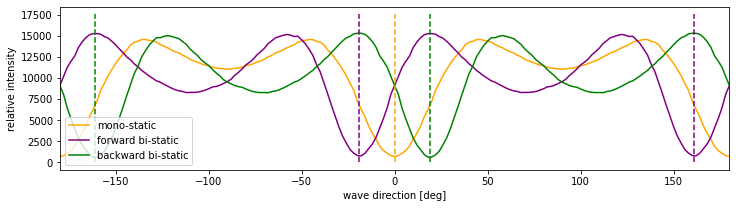

In [5]:
alpha_rot_deg=np.degrees(alpha_rot)
plt.figure(figsize=(12,3))
plt.plot(phi_d,np.convolve(P_sm,np.ones(5)/5,'same'),'orange',label='mono-static')
plt.plot(phi_d,np.convolve(P_sf,np.ones(5)/5,'same'),'purple',label='forward bi-static')
plt.plot(phi_d,np.convolve(P_sb,np.ones(5)/5,'same'),'green',label='backward bi-static')
plt.plot([0, 0],[0, np.max(P_sm*1.2)],'orange',linestyle='dashed')
plt.plot([-alpha_rot_deg, -alpha_rot_deg],[0, np.max(P_sm*1.2)],'purple',linestyle='dashed')
plt.plot([alpha_rot_deg, alpha_rot_deg],[0, np.max(P_sm*1.2)],'green',linestyle='dashed')
plt.plot([180-alpha_rot_deg, 180-alpha_rot_deg],[0, np.max(P_sm*1.2)],'purple',linestyle='dashed')
plt.plot([-180+alpha_rot_deg, -180+alpha_rot_deg],[0, np.max(P_sm*1.2)],'green',linestyle='dashed')
plt.xlabel('wave direction [deg]')
plt.ylabel('relative intensity')
plt.xlim(-180,180)
plt.legend(loc='lower left')
plt.savefig(outpath + 'Powervsdirection.png',dpi=300)

In [6]:
#f= open("/home/marcelmarina/Desktop/guru99.txt",'w+')
#for i in range(0,len(P_sm)):
#    f.write('%d,%d,%d,%d' % (phi_d[i],P_sm[i],P_sf[i],P_sb[i]))
    
#f.close()